In [1]:
import sys
import os
import re
import logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
from intake import open_esm_datastore
from ruamel.yaml import YAML
from dask.distributed import Client

In [2]:
from matplotlib import pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs

In [3]:
ryaml = YAML()
ryaml.preserve_quotes = True

In [4]:
client = Client(threads_per_worker=1)
client

INFO: State start
INFO: Found stale lock file and directory '/jobfs/129158806.gadi-pbs/dask-scratch-space/scheduler-3e27957u', purging
INFO:   Scheduler at:     tcp://127.0.0.1:37761
INFO:   dashboard at:         /proxy/8787/status
INFO: Registering Worker plugin shuffle
INFO:         Start Nanny at: 'tcp://127.0.0.1:36699'
INFO:         Start Nanny at: 'tcp://127.0.0.1:33661'
INFO:         Start Nanny at: 'tcp://127.0.0.1:41631'
INFO:         Start Nanny at: 'tcp://127.0.0.1:33655'
INFO:         Start Nanny at: 'tcp://127.0.0.1:33425'
INFO:         Start Nanny at: 'tcp://127.0.0.1:45729'
INFO:         Start Nanny at: 'tcp://127.0.0.1:37113'
INFO: Register worker <WorkerState 'tcp://127.0.0.1:43617', name: 4, status: init, memory: 0, processing: 0>
INFO: Starting worker compute stream, tcp://127.0.0.1:43617
INFO: Starting established connection to tcp://127.0.0.1:54244
INFO: Register worker <WorkerState 'tcp://127.0.0.1:42129', name: 6, status: init, memory: 0, processing: 0>
INFO: Sta

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37761,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44711,Total threads: 1
Dashboard: /proxy/37593/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:36699,


INFO: Event loop was unresponsive in Scheduler for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO: Event loop was unresponsive in Nanny for 3.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO: Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO: Event loop was unresponsive in Nanny for 3.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO: Event loop was unresponsive in Nanny for 3.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO: Event loop was unresponsive in Nanny for 3.30s.  This i

In [5]:
def _read_ryaml(yaml_path):
    """ Read yaml file and preserve comments"""
    with open(yaml_path, "r") as f:
        return ryaml.load(f)

In [6]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yamlfile_path = os.path.join(expts_manager_path, 'Expts_manager-025deg-75-layers.yaml')

In [7]:
def organise_input_info(MOM_dirs, MOM_names, MOM_full_paths):
    datastore_tot = []
    MOM_dirs_path_tot = []
    intake_esm_ds = 'intake_esm_ds.json'
    for i,j,k in zip(MOM_dirs,MOM_names,MOM_full_paths):
        archive_path = os.path.join(f"{output_expt_path}",f"{i}","archive")
        datastore_path = os.path.join(f"{archive_path}",intake_esm_ds)
        if os.path.isfile(datastore_path):
            datastore = open_esm_datastore(datastore_path,columns_with_iterables=["variable"])
            datastore_tot.append(datastore)
            MOM_dirs_path_tot.append(f"{k}")
    return datastore_tot, MOM_dirs_path_tot

In [8]:
yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
output_expt_path = os.path.join(expts_manager_path, test_rel_path)

MOM_dirs = yaml_input['namelists']['cross_block2']['cross_block2_dirs']  # directory names
MOM_names = MOM_dirs # ['KPP_ref'] # can be user-defined names in this script
MOM_full_paths= [os.path.join(expts_manager_path, test_rel_path, MOM_dir) for MOM_dir in MOM_dirs]
datastore_tot, MOM_dirs_path_tot = organise_input_info(MOM_dirs, MOM_names, MOM_full_paths)

In [9]:
xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [10]:
static = datastore_tot[0].search(path='.*output000.*',
                          frequency='fx', variable=['xh', 'yh', 'deptho', 'geolon', 'geolat']
                         ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)

In [11]:
static

<xarray.Dataset> Size: 20MB
Dimensions:  (yh: 1142, xh: 1440)
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
Data variables:
    geolat   (yh, xh) float32 7MB dask.array<chunksize=(1142, 1440), meta=np.ndarray>
    deptho   (yh, xh) float32 7MB dask.array<chunksize=(1142, 1440), meta=np.ndarray>
    geolon   (yh, xh) float32 7MB dask.array<chunksize=(1142, 1440), meta=np.ndarray>
Attributes: (12/19)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['geolat', 'deptho', 'geolon']
    intake_esm_attrs:path:                    /g/data/tm70/ml0072/COMMON/git_...
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   ['area:sum yh:sum xh:sum time: ...
    intake_esm_attrs:variable_units:          ['m2', 'm2', 'm2', 'm2', 'm', '...
    intake_esm_attrs:filename:                access-om3.mom6.static.nc
    intake_esm_attrs:file_id:                 access_om3_mom6_static
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_static.fx

In [12]:
class TruncationFilesReader(object):
    """
    A class to read, process and organise truncation files.
    This class provides methods to:
        Loads static grid coordinates.
        Parses and extract data from truncation files.
        Organises truncation data by specified variables (e.g., time or spatial attributes).

    Attributes:
        static: Dict[str, Any]: contains the static grid configuration
        archive_path: str: Path to the directory containing archived output files for processing.
        xh (np.ndarray): Longitude coordinates of the grid.
        yh (np.ndarray): Latitude coordinates of the grid.

    Methods:
        load_coords():
            Loads and returns the grid coordinates from the static configuration.
        process_truncation_files():
            Searches the archive directory for truncation files, parses them, and returns a list of truncation data.
        parse_truncation_files(truncation_files_path: str):
            Parses truncation files and extracts truncation data using regex.
        _extract_truncation_data(match):
            Extracts truncation details such as datetime, velocity type, processor adn etc.
        find_indices(target_lon, target_lat):
            Finds the closest grid indices and coordinates for a given longitude and latitude.
        convert_to_date_time(year, yearday, time):
            Converts year, yearday, and fractional time into a `datetime` object.
        truncation_organise_by_variable(truncation_data, trunc_variable):
            Organises truncation data by a specified variable (e.g., month, year, processor).
    """

    def __init__(self, static, archive_path):
        self.static = static
        self.archive_path = archive_path
        self.xh, self.yh = self.load_coords()

    def load_coords(self):
        return (
            self.static["xh"],
            self.static["yh"],
        )

    def process_truncation_files(self):
        all_truncation_data = []

        for output_dir in os.listdir(self.archive_path):
            output_dir_path = os.path.join(self.archive_path, output_dir)
            if os.path.isdir(output_dir_path) and output_dir.startswith("output"):
                for filename in os.listdir(output_dir_path):
                    if filename.startswith(
                        "U_velocity_truncations"
                    ) or filename.startswith("V_velocity_truncations"):
                        truncation_files_path = os.path.join(output_dir_path, filename)
                        logging.info(truncation_files_path)
                        truncation_data = self.parse_truncation_files(
                            truncation_files_path
                        )
                        if truncation_data:
                            all_truncation_data.append(truncation_data)
        if not all_truncation_data:
            logging.warning(f"No velocity truncations exist in {self.archive_path}.")
        return all_truncation_data

    def parse_truncation_files(self, truncation_files_path):
        trunc_pattern = re.compile(
            r'Time\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([UV])-velocity violation at\s+(\d+):\s+\d+\s+\d+\s+\(\s*([-+]?\d*\.\d+)\s+[E]?\s+([-+]?\d*\.\d+)\s+[N]?\)\s+Layers\s+(\d+)\s+to\s+(\d+)\.\s+dt\s+=\s+(\d+)'
        )
        truncations = []

        try:
            with open(truncation_files_path, "r") as f:
                file_read = f.read()
            for match in trunc_pattern.finditer(file_read):
                truncations.append(self._extract_truncation_data(match))
        except FileNotFoundError:
            logging.error(f"Files not found: {truncation_files_path}")
        except Exception as e:
            logging.error(f"Error processing file {truncation_files_path}: {e}")
        return truncations

    def _extract_truncation_data(self, match):
        year = int(match.group(1))
        yearday = int(match.group(2))
        time_of_day = float(match.group(3))
        velocity_type = match.group(4) + "-velocity"
        processor = int(match.group(5))
        lon = float(match.group(6))
        lat = float(match.group(7))
        layer_start = int(match.group(8))
        layer_end = int(match.group(9))
        dt = int(match.group(10))

        (
            nearest_idx,
            nearest_lon_idx,
            nearest_lat_idx,
            nearest_lon,
            nearest_lat,
            nearest,
        ) = self.find_indices(lon, lat)
        datetime_value = self.convert_to_date_time(year, yearday, time_of_day)

        return {
            "datetime": datetime_value,
            "velocity_type": velocity_type,
            "processor": processor,
            "longitude": lon,
            "latitude": lat,
            "longitude_index": nearest_lon_idx,
            "latitude_index": nearest_lat_idx,
            "eval_longitude": nearest_lon,
            "eval_latitude": nearest_lat,
            "layers_start": layer_start,
            "layers_end": layer_end,
            "dt": dt,
        }

    def find_indices(self, target_lon, target_lat):
        if hasattr(self.xh, "values"):
            xh = self.xh.values
        if hasattr(self.yh, "values"):
            yh = self.yh.values

        lon_diff = np.abs(xh - target_lon)
        lat_diff = np.abs(yh - target_lat)

        nearest_lon_idx = np.argmin(lon_diff)
        nearest_lat_idx = np.argmin(lat_diff)
        return (
            (nearest_lat_idx, nearest_lon_idx),
            nearest_lon_idx,
            nearest_lat_idx,
            xh[nearest_lon_idx],
            yh[nearest_lat_idx],
            (yh[nearest_lat_idx], xh[nearest_lon_idx]),
        )

    def convert_to_date_time(self, year, yearday, time):
        yearday = max(1, yearday)
        tmp = datetime(year, 1, 1)
        target_date = tmp + timedelta(days=yearday - 1)

        hours = int(time)
        minutes = int((time - hours) * 60)
        seconds = int((((time - hours) * 60) - minutes) * 60)
        return target_date + timedelta(hours=hours, minutes=minutes, seconds=seconds)

    def truncation_organise_by_variable(self, truncation_data, trunc_variable):
        """
        trunc_variable: one of those in the output of _extract_truncation_data(self, match), special case for `datetime` variable.
        """
        group_data = defaultdict(list)
        for trunc in truncation_data:
            for i in trunc:
                if trunc_variable == "trunc_month":
                    v = i["datetime"].month
                elif trunc_variable == "trunc_day":
                    v = i["datetime"].day
                elif trunc_variable == "trunc_year":
                    v = i["datetime"].year
                else:
                    v = i.get(trunc_variable)
                group_data[v].append(i)
        trunc_keys = list(group_data.keys())
        logging.info(f"Available truncation keys: {list(group_data.keys())}")
        return dict(group_data), trunc_keys

In [13]:
archive_path = os.path.join(MOM_dirs_path_tot[0], 'archive')
truncation_reader = TruncationFilesReader(static, archive_path)
xh, yh = truncation_reader.load_coords()
all_truncation_data = truncation_reader.process_truncation_files()
trunc_variable = 'trunc_month'
orgnised_data, trunc_keys = truncation_reader.truncation_organise_by_variable(all_truncation_data, trunc_variable)

INFO: /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/truncation_check/archive/output000/U_velocity_truncations.1221
INFO: /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/truncation_check/archive/output000/V_velocity_truncations.1038
INFO: /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/truncation_check/archive/output000/U_velocity_truncations.1039
INFO: /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/truncation_check/archive/output000/U_velocity_truncations.1011
INFO: Available truncation keys: [1]


In [14]:
deptho = static["deptho"].load()
lon_coord = "longitude"
lat_coord = "latitude"
deptho = deptho.assign_coords({lon_coord: (["yh", "xh"], static["geolon"].values), lat_coord: (["yh", "xh"], static["geolat"].values)})

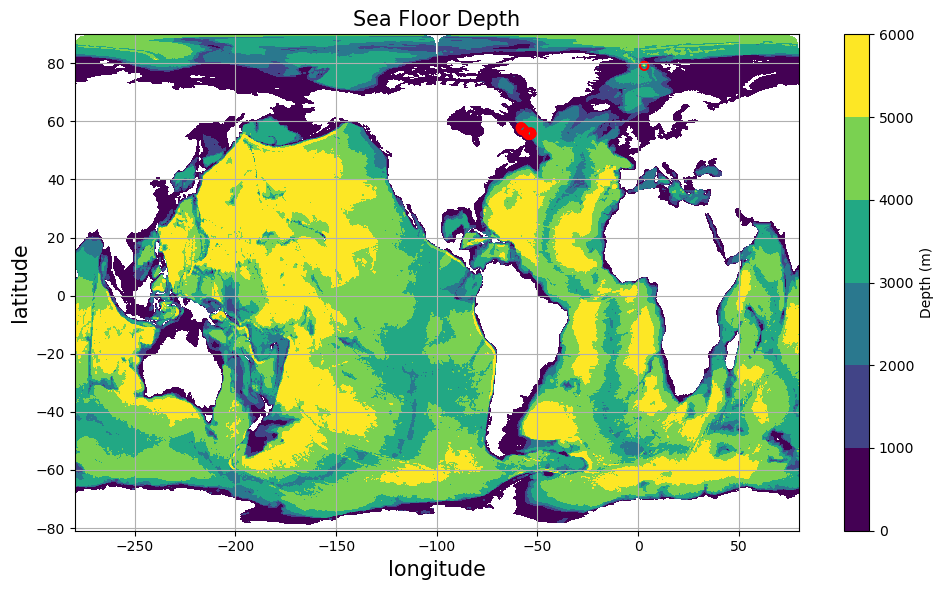

In [15]:
figsize = (10, 6)
fig, ax = plt.subplots(figsize=figsize)

deptho.plot.contourf(
    ax=ax,
    x='longitude',
    y='latitude',
    cmap='viridis',
    cbar_kwargs={'label': 'Depth (m)'}
)

trunc_keys = [trunc_keys] if not isinstance(trunc_keys, list) else trunc_keys

for trunc_tmp in trunc_keys:
    if trunc_tmp in orgnised_data:
        lon_indices = [i['longitude_index'] for i in orgnised_data[trunc_tmp]]
        lat_indices = [i['latitude_index'] for i in orgnised_data[trunc_tmp]]
        ax.scatter(xh[lon_indices].values, yh[lat_indices].values, facecolors='none', edgecolors='r')

ax.grid(True)
title = deptho.attrs.get("long_name", "")
ax.set_title(title, fontsize=15)
ax.set_xlabel(ax.get_xlabel(), fontsize=15)
ax.set_ylabel(ax.get_ylabel(), fontsize=15)
xlims = [min(xh), max(xh)]
ylims = [min(yh), max(yh)]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.tight_layout()